### ANÁLISE E PREVISÃO DA ARRECADAÇÃO FEDERAL

Autor: GABRIEL RODRIGUES  MARCOLINI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
#Define parâmetros iniciais
dataset_path = '.\\dataset\\CSV\\'
filename_input = 'arrecadacao-TOTAL-GERAL-2015-2020.csv'
indicadores = 'xgdvConsulta.csv'

In [3]:
#Faz a leitura dos datasets
#tb = tabela de Arrecadação Federal
#ie = tabela de indicadores econômicos
tb = pd.read_csv(dataset_path+filename_input) 
ie = pd.read_csv(dataset_path+indicadores,sep=';',decimal=',')

In [4]:
#Ajusta o campo DATA do dataframe ie
ie['DATA'] =  pd.to_datetime(ie['DATA'],format="%m/%Y") + pd.tseries.offsets.MonthEnd(0)

In [5]:
#Ajusta o campo DATA do dataframe tb
tb['DATA'] = pd.to_datetime(tb['DATA'],format="%Y/%m/%d")

In [6]:
#Unindo os dataframes tb + ie
left = tb.groupby([tb['DATA']]).sum()
right = ie
result = pd.merge(left,right,how='inner',on='DATA')

In [7]:
# Criando um novo DF para tratar os desvios de arrecadação (outliers) observados em 10/2016 e 04, 05 e 06/2020.
# Os valores serão substitudo pelo valor arrecadado no mesmo mês do ano anterior. 
#outliers = ['2016-10-31','2020-04-30','2020-05-31','2020-06-30']

result_n = result.copy()

result_n.loc[(result_n['DATA'] == '2016-10-31'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2015-10-31'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-04-30'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-04-30'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-05-31'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-05-31'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-06-30'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-06-30'),'VALOR'].values

In [8]:
#Define função para calcular o MAPE - Mean Absolute Percentage Error
def mape(y_pred,y_true):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
# Ajustar parâmetros de plotagem
#plt.rcParams.keys()
plt.rcParams["text.color"] = 'Blue'
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.figsize"] = [15, 6]
plt.rcParams["lines.linewidth"] = 2.0

In [10]:
# Definindo o DataFrame a ser analisado
df_real = result.groupby([result['DATA']]).sum()['VALOR']
df_normal = result_n.groupby([result_n['DATA']]).sum()['VALOR']
df = df_normal

### Buscando valores de 'p' e 'q'

In [11]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

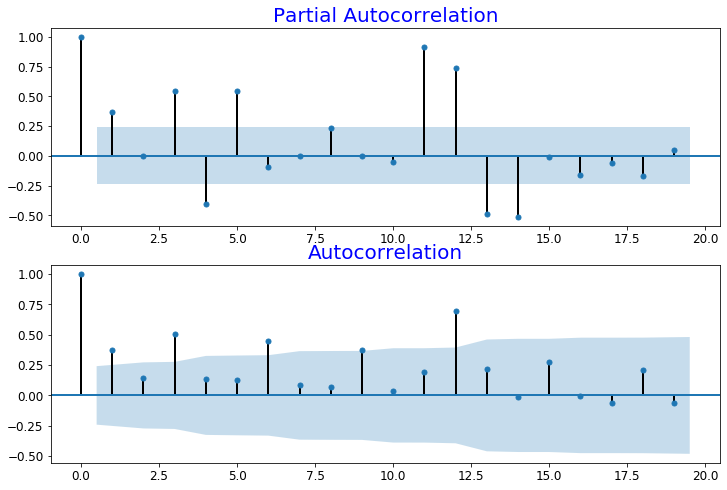

In [12]:
#Plotando Grafico de Autocorrelação e Autocorrelação Parcial
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_pacf(df, ax = ax1, method='ols') # identifica p = AR
plot_acf(df, ax = ax2) # Identifica q = MA
plt.show()

## Modelo SARIMA

In [13]:
import statsmodels.api as sm

In [14]:
# Separa os dados em treino e teste
train, test = df[0:-17], df[-17:]

In [15]:
#Ajusta o modelo com base nos dados de treino
model_sarimax = sm.tsa.SARIMAX(train,order=(2,1,1), seasonal_order=(1,1,3,12), freq = 'M', enforce_stationarity=True)
model_sarimax_fit = model_sarimax.fit()

C:\Users\grmar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


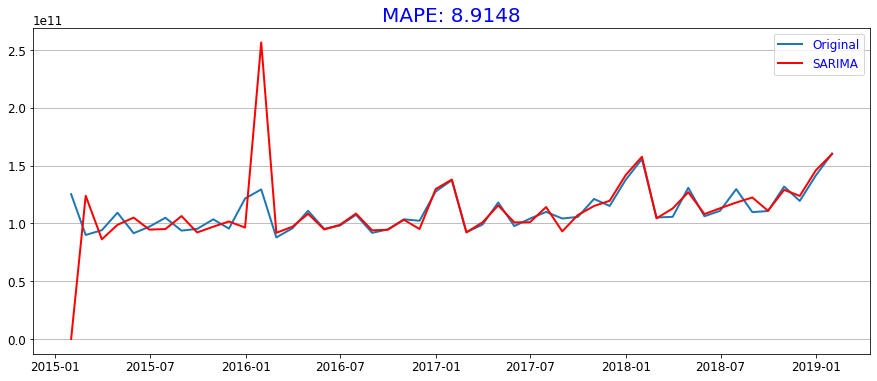

In [16]:
#Plota o resultado do desempenho durante o treino
plt.plot(train, label='Original')
plt.plot(model_sarimax_fit.fittedvalues, color='red', label='SARIMA')
plt.title('MAPE: %.4f' % mape(model_sarimax_fit.fittedvalues,train))
plt.grid(True,axis='y')
plt.legend(loc='best')

In [17]:
# Faz a previsão com base no tamanho da base de teste
yhat = model_sarimax_fit.forecast(len(test))

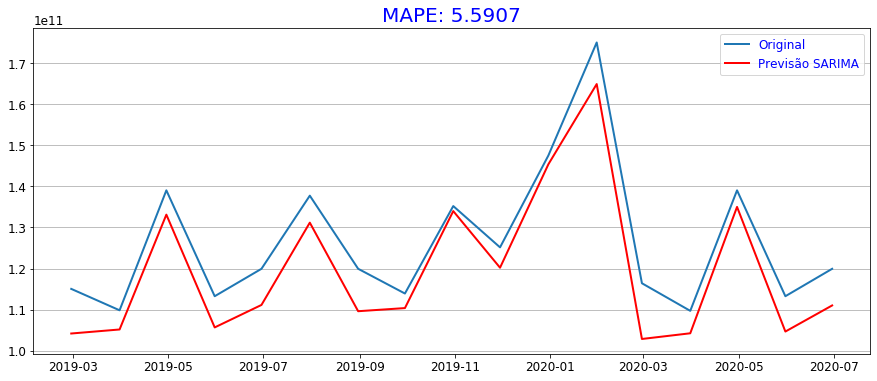

In [18]:
#Plota o resultado
plt.plot(test, label='Original')
plt.plot(yhat, color='red', label='Previsão SARIMA')
plt.title('MAPE: %.4f' % mape(yhat,test))
plt.grid(True,axis='y')
plt.legend(loc='best')

In [19]:
#Ajusta o modelo utilizando toda a base de dados
model_sarimax = sm.tsa.SARIMAX(df,order=(2,1,1), seasonal_order=(1,1,3,12), freq = 'M', enforce_stationarity=True)
model_sarimax_fit = model_sarimax.fit(disp=False)

C:\Users\grmar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


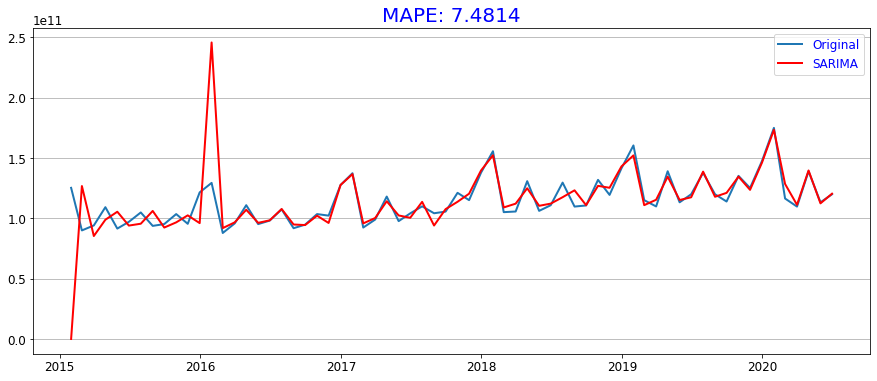

In [20]:
# Plota o resultado
plt.plot(df, label='Original')
plt.plot(model_sarimax_fit.fittedvalues, color='red', label='SARIMA')
plt.title('MAPE: %.4f' % mape(model_sarimax_fit.fittedvalues,df))
plt.grid(True,axis='y')
plt.legend(loc='best')